In [1]:
! pip install statsmodel
! pip install nsepy
! pip install pylab
! pip install pmdarima

ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36083 sha256=8b459800a8fae74e92169cdf409686c4ba53a88a862953f21a73c491e0a65a7b
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy
ERROR: Could not find a version that satisfies the requirement pylab (from versions: none)
ERROR: No matching distribution found for pylab
     |████████████████████████████████| 1.5 MB 283 kB/s 


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

https://nsepy.xyz/

In [3]:
df=pd.read_csv("../input/tcsdataset/NSEI.csv")
df[0:5]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900.0
1,2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,8378.400391,118200.0
2,2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,8127.350098,172800.0
3,2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,8102.100098,164100.0
4,2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,8234.599609,143800.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1228 non-null   object 
 1   Open       1221 non-null   float64
 2   High       1221 non-null   float64
 3   Low        1221 non-null   float64
 4   Close      1221 non-null   float64
 5   Adj Close  1221 non-null   float64
 6   Volume     1221 non-null   float64
dtypes: float64(6), object(1)
memory usage: 67.3+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1.221000e+03
mean,9632.946158,9673.082975,9574.905481,9624.031004,9624.031004,2.578615e+05
std,1396.858237,1399.373239,1391.436162,1395.584360,1395.584360,1.593881e+05
min,7023.649902,7034.200195,6825.799805,6970.600098,6970.600098,0.000000e+00
25%,8376.750000,8413.200195,8322.250000,8361.000000,8361.000000,1.634000e+05
50%,9657.150391,9684.250000,9637.450195,9657.549805,9657.549805,2.033000e+05
75%,10813.250000,10850.549805,10750.150391,10801.849609,10801.849609,2.955000e+05
max,12274.900391,12293.900391,12252.750000,12271.799805,12271.799805,1.414800e+06


In [6]:
df=df.dropna()

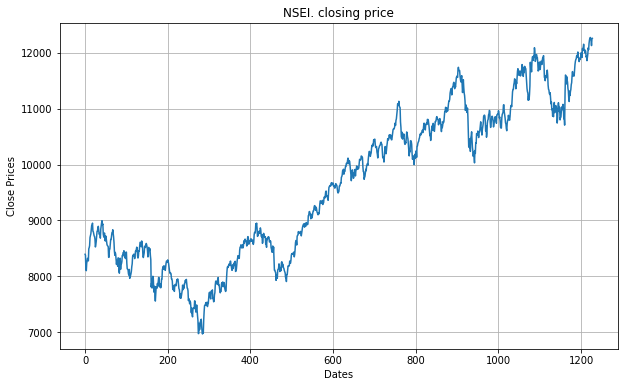

In [7]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('NSEI. closing price')
plt.show()

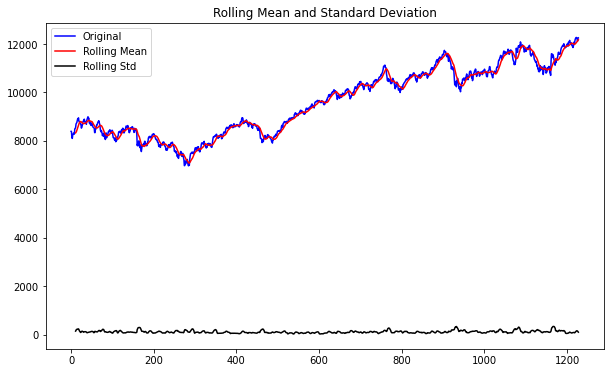

Results of dickey fuller test
Test Statistics                  -0.250285
p-value                           0.932256
No. of lags used                 10.000000
Number of observations used    1210.000000
critical value (1%)              -3.435766
critical value (5%)              -2.863932
critical value (10%)             -2.568043
dtype: float64


In [8]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

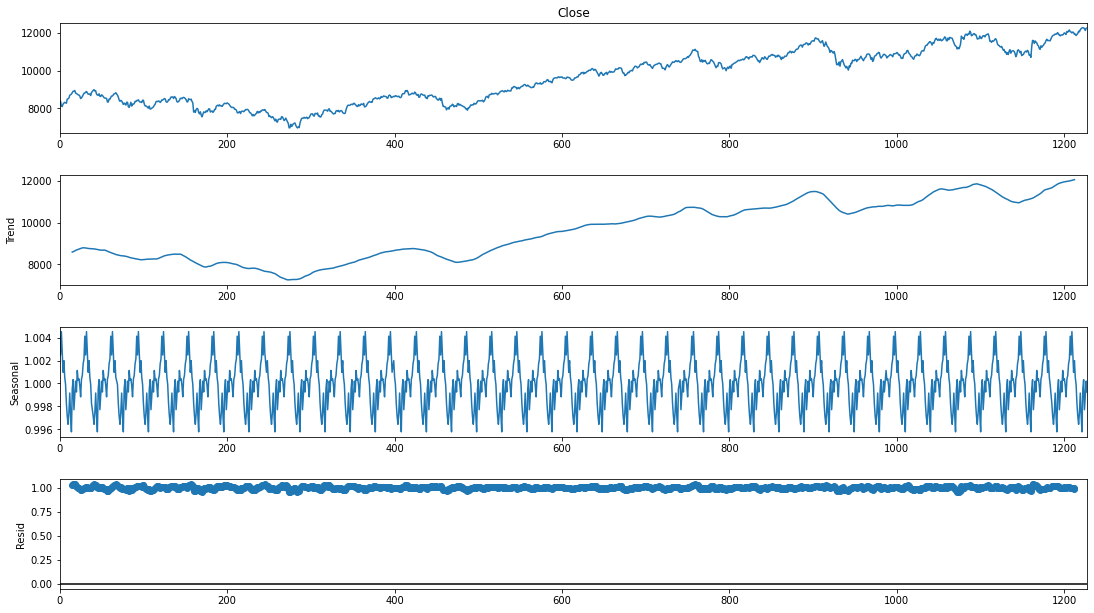

In [9]:
result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

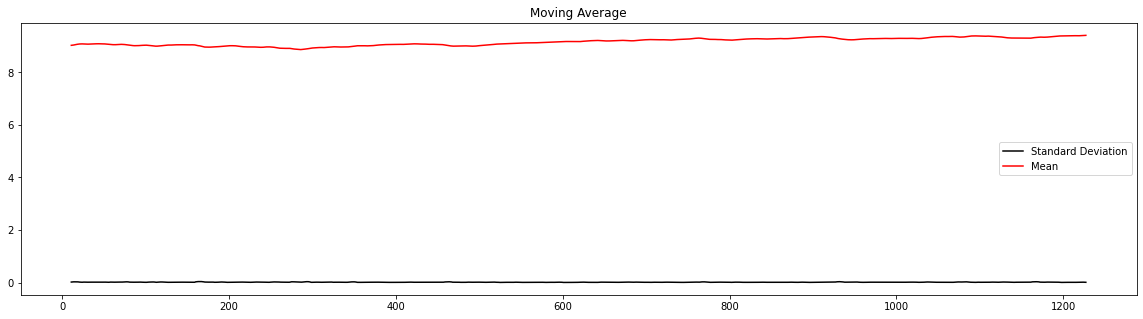

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

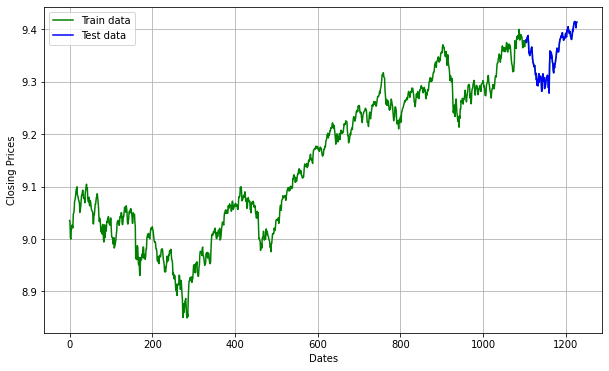

In [11]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7325.876, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7328.024, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7328.027, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7326.045, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7326.026, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7326.020, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7324.024, Time=0.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7328.389, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7326.395, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-7326.386, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7328.397, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7326.396, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-7324.397, Time=0.36 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.424 seconds
         

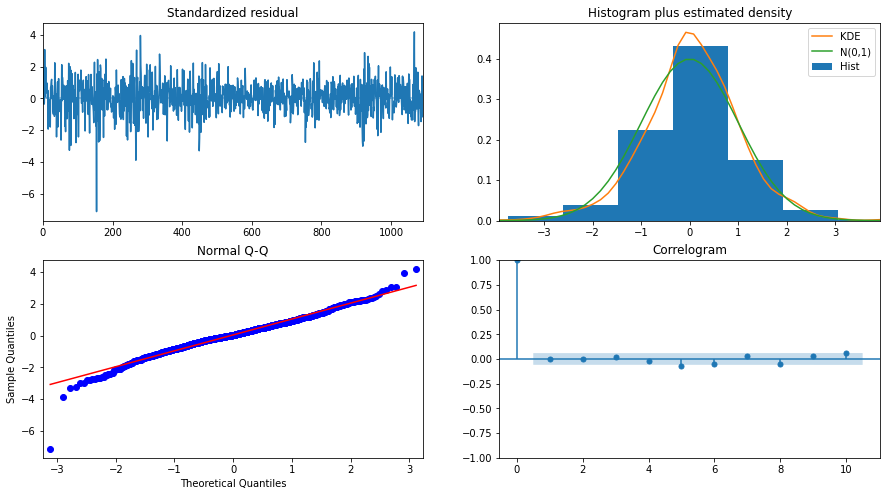

In [13]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [14]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1094
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3669.052
Method:                       css-mle   S.D. of innovations              0.008
Date:                Sun, 29 Aug 2021   AIC                          -7324.104
Time:                        16:01:42   BIC                          -7289.121
Sample:                             1   HQIC                         -7310.866
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.282      0.200      -0.000       0.001
ar.L1.D.Close    -0.5869      0.118     -4.963      0.000      -0.819      -0.355
ar.L2.D.Close    -0.9028      0.081    -

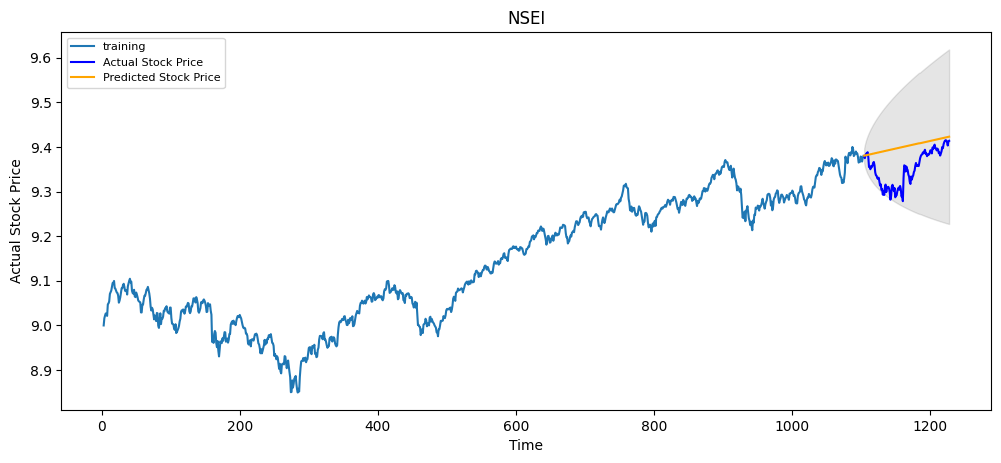

In [15]:
fc, se, conf = fitted.forecast(123, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('NSEI')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0034950816695954257
MAE: 0.0494874260232289
RMSE: 0.05911921573900846
MAPE: 0.005305197979565658


https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html